In [ ]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import math
from marketdatalib import map_scrip_to_yfin_ticker, get_nifty_index_data, calculate_beta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import riskfolio as rp
from scipy.optimize import minimize
import yfinance as yf

In [44]:
# Number of year of historic data to consider
YEARS_OF_HISTORY = 5

# The risk free return rate. This is often the return on a 10 year government bond.
# At present, the 10 year government bond rate is 6.84%. We are using 7.5% for the sake of simplicity which is the rate of a fixed deposit.
RISK_FREE_RETURN = 0.075
EXPECTED_MARKET_RETURN = 0.18
ACCEPTABLE_VOLATILITY = 0.15

# In intend to evaluate the performance of the portfolio, we will compare it with the performance of the benchmark index.
BENCHMARK_INDEX_NIFTY500 = 'NIFTY%20500'

scripts_to_ignore = ['SONACOMS']
special_scrips = ['ARE&M']

In [45]:
# Get benchmark data
NIFTY500_DATA = get_nifty_index_data(index_name=BENCHMARK_INDEX_NIFTY500, number_of_years=YEARS_OF_HISTORY)
NIFTY500_DATA.drop(columns=['Open', 'High', 'Low'], inplace=True)
NIFTY500_DATA['NIFTY500_returns'] = NIFTY500_DATA['Close'].pct_change(fill_method=None)
NIFTY500_DATA['NIFTY500_log_returns'] = NIFTY500_DATA['Close'].apply(lambda x: math.log(x)).diff()
NIFTY500_DATA.dropna(inplace=True, axis=0)
NIFTY500_DATA.rename(columns={'Close': 'NIFTY500'}, inplace=True)
# NIFTY500_DATA[['Close', 'NIFTY500_returns', 'NIFTY500_log_returns']]
NIFTY500_DATA

,NIFTY500,NIFTY500_returns,NIFTY500_log_returns
Date,,,
2019-11-05,9694.05,-0.003940,-0.003948
2019-11-06,9721.35,0.002816,0.002812
2019-11-07,9764.30,0.004418,0.004408
2019-11-08,9683.30,-0.008296,-0.008330
2019-11-11,9695.85,0.001296,0.001295
...,...,...,...
2024-10-28,22649.95,0.006707,0.006685
2024-10-29,22795.05,0.006406,0.006386
2024-10-30,22749.80,-0.001985,-0.001987


Since I'll be running this exercise on my own portfolio, there are things that I need to hide before I commit the same to githud :-). So, assume that I have CSV of the stocks that I hold and I'll be using that to run this exercise.

In [46]:
holdings = pd.read_csv('../../data/MarketData/holdings.csv', names={'Instrument': 'Instrument', 'Quantity': 'Qty.', 'AvgCost': 'Avg. cost', 'LTP': 'LTP', 'CurVal': 'Cur. val', 'P&L': 'P&L', 'NetChg_Pct': 'Net chg.', 'DayChange_Pct': 'Day chg.', '':''}, header=0, index_col=0)
holdings = holdings.loc[:, holdings.columns != '']

indices_to_remove = [idx for idx in scripts_to_ignore if idx in holdings.index]
holdings = holdings.drop(indices_to_remove, axis=0)

holdings['Weight'] = holdings['CurVal'] / holdings['CurVal'].sum()

portfolio_stocks = [map_scrip_to_yfin_ticker(scrip, 'NSE' if scrip not in special_scrips else 'BSE') for scrip in holdings.index]
holdings

,Quantity,AvgCost,LTP,CurVal,P&L,NetChg_Pct,DayChange_Pct,Weight
Instrument,,,,,,,,
ARE&M,16,1370.52,1390.60,22249.60,321.30,1.47,2.53,0.004631
AXISBANK,137,1164.84,1158.50,158714.50,-869.20,-0.54,-1.20,0.033031
BAJAJ-AUTO,4,9576.54,9836.30,39345.20,1039.05,2.71,-1.05,0.008188
BAJAJHLDNG,1,9789.15,10249.50,10249.50,460.35,4.70,0.26,0.002133
COALINDIA,100,443.80,452.30,45230.00,850.00,1.92,0.61,0.009413
ENDURANCE,6,2639.04,2374.65,14247.90,-1586.35,-10.02,1.42,0.002965
EXIDEIND,20,562.26,455.15,9103.00,-2142.20,-19.05,-2.18,0.001894
GESHIP,187,1277.90,1289.40,241117.80,2151.40,0.90,0.11,0.050181
HDFCBANK,1134,1477.96,1734.95,1967433.30,291421.85,17.39,0.00,0.409457


In [47]:
master_data = pd.DataFrame()

start_date = datetime.today() - relativedelta(years=YEARS_OF_HISTORY)

scrips = [scrip for scrip, ticker in portfolio_stocks]
assets = [ticker.ticker for _, ticker in portfolio_stocks]

master_data = yf.download(assets, start = start_date)
master_data = master_data.loc[:,('Adj Close', slice(None))]
master_data.columns = scrips
master_data.index = pd.to_datetime(master_data.index)
master_data = master_data.sort_index()
master_data

[*********************100%%**********************]  21 of 21 completed


,ARE&M,AXISBANK,BAJAJ-AUTO,BAJAJHLDNG,COALINDIA,ENDURANCE,EXIDEIND,GESHIP,HDFCBANK,HEROMOTOCO,...,IDFCFIRSTB,ITC,KOTAKBANK,KPITTECH,M&M,MOTHERSON,NMDC,POWERGRID,SUNDRMFAST,TATAPOWER
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-04,623.364868,739.378418,2756.288818,3397.494873,133.378387,1088.040649,177.046921,245.740082,1187.349365,2305.359863,...,43.700001,211.363846,1566.317627,88.939850,555.700684,48.702827,58.630241,82.171631,448.945953,55.889168
2019-11-05,621.851013,734.848145,2785.678955,3414.991455,130.989960,1082.459106,178.180008,246.118362,1189.893433,2324.109619,...,43.049999,213.106644,1549.219360,89.181915,549.777893,49.051807,59.509701,82.445892,448.030518,54.953003
2019-11-06,625.635803,744.008240,2787.395020,3415.586914,131.765427,1090.341675,176.055466,245.572083,1206.357056,2335.751953,...,42.500000,211.850220,1566.317627,86.954796,549.446167,51.106949,60.469109,82.319298,447.307861,55.140240
2019-11-07,626.534668,731.562500,2802.455078,3480.853516,131.827469,1098.860840,178.180008,245.782181,1213.125000,2320.490479,...,42.450001,215.497910,1579.228638,87.148445,549.967346,52.037571,57.297741,81.939568,453.089539,54.999813
2019-11-08,618.823059,722.352661,2785.035400,3459.922607,129.811279,1073.107788,176.149902,251.497040,1205.349121,2308.368408,...,42.150002,211.161209,1595.429688,87.148445,549.635742,50.118156,55.298985,80.863625,452.993134,55.748737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-28,1321.099976,1171.599976,10011.250000,10223.849609,441.649994,2350.399902,464.049988,1245.750000,1734.199951,4927.799805,...,67.129997,484.149994,1749.849976,1386.250000,2781.000000,190.449997,227.960007,318.299988,1307.099976,425.700012
2024-10-29,1330.650024,1186.849976,9850.849609,10355.250000,445.549988,2333.850098,467.049988,1239.650024,1751.849976,4787.450195,...,67.599998,487.950012,1760.199951,1368.750000,2746.899902,190.270004,226.139999,320.549988,1329.449951,425.399994
2024-10-30,NaN,1170.400024,9940.650391,10223.299805,449.149994,2341.449951,465.250000,1287.949951,1734.599976,4909.299805,...,68.790001,491.549988,1734.599976,1385.300049,2707.699951,185.059998,224.259995,318.450012,1331.750000,427.000000


In [48]:
def encich_with_returns(data: pd.DataFrame):
    for scrip, _ in portfolio_stocks:
        data[scrip + '_returns'] = data[scrip].pct_change(fill_method=None)
        # data[scrip + '_log_returns'] = data[scrip].apply(lambda x: math.log(x)).diff()
    data.dropna(inplace=True, axis=0)
    return data

master_data = encich_with_returns(master_data)
master_data = pd.merge(master_data, NIFTY500_DATA, left_index=True, right_index=True)
master_data

,ARE&M,AXISBANK,BAJAJ-AUTO,BAJAJHLDNG,COALINDIA,ENDURANCE,EXIDEIND,GESHIP,HDFCBANK,HEROMOTOCO,...,KPITTECH_returns,M&M_returns,MOTHERSON_returns,NMDC_returns,POWERGRID_returns,SUNDRMFAST_returns,TATAPOWER_returns,NIFTY500,NIFTY500_returns,NIFTY500_log_returns
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-05,621.851013,734.848145,2785.678955,3414.991455,130.989960,1082.459106,178.180008,246.118362,1189.893433,2324.109619,...,0.002722,-0.010658,0.007165,0.015000,0.003338,-0.002039,-0.016750,9694.05,-0.003940,-0.003948
2019-11-06,625.635803,744.008240,2787.395020,3415.586914,131.765427,1090.341675,176.055466,245.572083,1206.357056,2335.751953,...,-0.024973,-0.000603,0.041897,0.016122,-0.001535,-0.001613,0.003407,9721.35,0.002816,0.002812
2019-11-07,626.534668,731.562500,2802.455078,3480.853516,131.827469,1098.860840,178.180008,245.782181,1213.125000,2320.490479,...,0.002227,0.000949,0.018209,-0.052446,-0.004613,0.012925,-0.002547,9764.30,0.004418,0.004408
2019-11-08,618.823059,722.352661,2785.035400,3459.922607,129.811279,1073.107788,176.149902,251.497040,1205.349121,2308.368408,...,0.000000,-0.000603,-0.036885,-0.034884,-0.013131,-0.000213,0.013617,9683.30,-0.008296,-0.008330
2019-11-11,679.664490,730.517090,2777.999023,3399.235596,130.183517,1076.583984,179.974091,253.934311,1214.132935,2262.191162,...,0.005000,-0.008621,0.038298,-0.000964,0.000522,-0.019783,-0.034425,9695.85,0.001296,0.001295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-24,1264.000000,1167.349976,10302.500000,10117.299805,477.250000,2394.949951,466.899994,1252.699951,1749.650024,5113.600098,...,-0.136857,0.011759,-0.026312,-0.011132,0.007100,0.014075,0.000685,22787.85,-0.002331,-0.002334
2024-10-25,1241.849976,1189.349976,10206.099609,10156.450195,461.100006,2376.100098,449.899994,1246.900024,1743.400024,4973.299805,...,-0.026403,-0.037327,-0.014343,0.009173,-0.010497,-0.019009,-0.036301,22499.05,-0.012673,-0.012754
2024-10-28,1321.099976,1171.599976,10011.250000,10223.849609,441.649994,2350.399902,464.049988,1245.750000,1734.199951,4927.799805,...,0.009209,0.022107,0.004112,0.046504,0.007916,-0.044238,0.008529,22649.95,0.006707,0.006685


At this point of time, we will compute a few portfolio specific statistics that are agnostic of weights of individual stocks in the poortfolio.
- Covariance matrix

In [49]:
covariance_matrix = master_data[[scrip + '_returns' for scrip in scrips]].cov().to_numpy()

In [50]:
realized_returns = pd.DataFrame(index=[scrip for scrip, _ in portfolio_stocks], columns=['Returns', 'AnnualizedReturns', 'DailyVolatility', 'AnnualizedVolatility', 'SharpeRatio', 'SortinoRatio', 'JensensAlpha', 'Beta'])

market_std = master_data['NIFTY500_returns'].std()

for scrip in scrips:
    realized_returns.loc[scrip, 'Returns'] = (master_data[scrip + '_returns'] + 1).prod() - 1

    # Calculate average daily return
    avg_daily_return = np.mean(master_data[scrip + '_returns'])
    annualized_return = (1 + avg_daily_return).mean() ** 252 - 1
    # Calculate downside deviation
    downside_returns = master_data[scrip + '_returns'][master_data[scrip + '_returns'] < 0]
    downside_deviation = np.std(downside_returns)
    annualized_downside_deviation = downside_deviation * np.sqrt(252)
    daily_volatility = (master_data[scrip + '_returns']).std()
    annualized_volatility = daily_volatility * math.sqrt(252)
    beta = calculate_beta(master_data[scrip + '_returns'], master_data['NIFTY500_returns'])

    realized_returns.loc[scrip, 'DailyVolatility'] = daily_volatility
    annualized_std = realized_returns.loc[scrip, 'AnnualizedVolatility'] = annualized_volatility
    realized_returns.loc[scrip, 'AnnualizedReturns'] = annualized_return
    realized_returns.loc[scrip, 'SharpeRatio'] = (realized_returns.loc[scrip, 'AnnualizedReturns'] - RISK_FREE_RETURN) / annualized_std
    
    realized_returns.loc[scrip, 'Beta'] = beta
    realized_returns.loc[scrip, 'ExpectedReturn'] = RISK_FREE_RETURN + beta * (EXPECTED_MARKET_RETURN - RISK_FREE_RETURN)

    # Calculate Sortino Ratio
    sortino_ratio = (annualized_return - RISK_FREE_RETURN) / annualized_downside_deviation

    realized_returns.loc[scrip, 'SortinoRatio'] = sortino_ratio
    # 'JensensAlpha'
    # Calculate Jensen's Alpha
    realized_returns.loc[scrip, 'JensensAlpha'] = realized_returns.loc[scrip, 'AnnualizedReturns'] - (RISK_FREE_RETURN + beta * (EXPECTED_MARKET_RETURN - RISK_FREE_RETURN))

realized_returns

,Returns,AnnualizedReturns,DailyVolatility,AnnualizedVolatility,SharpeRatio,SortinoRatio,JensensAlpha,Beta,ExpectedReturn
ARE&M,1.39542,0.274293,0.022034,0.349778,0.569771,0.86969,0.092293,1.019048,0.182000
AXISBANK,0.430997,0.155518,0.023307,0.36998,0.217628,0.267786,-0.065787,1.39338,0.221305
BAJAJ-AUTO,2.337337,0.334715,0.017237,0.273631,0.949143,1.263732,0.177914,0.779056,0.156801
BAJAJHLDNG,1.379392,0.268262,0.021135,0.335507,0.576029,0.725901,0.107475,0.817017,0.160787
COALINDIA,2.218613,0.347462,0.020837,0.330772,0.823716,1.232391,0.174893,0.929234,0.172570
ENDURANCE,1.128576,0.233408,0.020416,0.324099,0.488765,0.763569,0.097229,0.582661,0.136179
EXIDEIND,1.306113,0.248726,0.019613,0.311353,0.557972,0.868769,0.072893,0.960321,0.175834
GESHIP,4.069899,0.524608,0.025862,0.41054,1.095162,1.725122,0.357268,0.879429,0.167340
HDFCBANK,0.646318,0.151353,0.017122,0.271797,0.28092,0.369334,-0.033898,1.050015,0.185252
HEROMOTOCO,0.882362,0.192438,0.018739,0.297475,0.394784,0.567981,0.026095,0.869935,0.166343


The above table represents the the statistics associated with each of the security in our portfolio. The benchmark index that we're using for calculations is the NIFTY 500 TRI index. The expected return above is based on the current weightage of each of the security in the portfolio.

- The expected return is calculated by multiplying the weightage of each security with the expected return of the security.
- The Sharpe ratio of the portfolio is calculated by dividing the expected return of the portfolio by the standard deviation of the portfolio. The Sharpe ratio of the portfolio is used to calculate the risk-adjusted return of the portfolio.
- The risk-adjusted return of the portfolio is calculated by multiplying the Sharpe ratio of the portfolio with the expected return of the portfolio. The risk-adjusted return of the portfolio is used to calculate the risk-adjusted return of each security. The risk-adjusted return of each security is calculated by multiplying the Sharpe ratio of the portfolio with the expected return of the security.

In [51]:
portfolio_expected_return = holdings['Weight'].dot(realized_returns['ExpectedReturn'])

weights = holdings['Weight']

portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))

# Calculate the portfolio standard deviation (volatility)
portfolio_std_dev = np.sqrt(portfolio_variance)

# Calculate the Sharpe Ratio
portfolio_sharpe_ratio = (portfolio_expected_return - RISK_FREE_RETURN) / portfolio_std_dev

# Calculate prtfolio beta
portfolio_beta = np.dot(weights.T, realized_returns['Beta'])

print('Expected Portfolio Return: {0:.2f}%'.format(portfolio_expected_return * 100))
print('Expected Portfolio Volatility: {0:.2f}%'.format(portfolio_std_dev * 100))
print('Portfolio Beta: {0:.2f}'.format(portfolio_beta))
print('Sharpe Ratio of Portfolio: {0:.2f}'.format(portfolio_sharpe_ratio))
print('Risk adjusted return of Portfolio: {0:.2f}'.format(portfolio_sharpe_ratio * portfolio_expected_return))

Expected Portfolio Return: 18.87%
Expected Portfolio Volatility: 1.44%
Portfolio Beta: 1.08
Sharpe Ratio of Portfolio: 7.92
Risk adjusted return of Portfolio: 1.49


One extremely important factor that we need to keep in mind is that for the sake of simplicity and for lack of data, we've only considered the last 5 years of benchmark data. This is going to hide the fact that the market might have given an extremely high return in the last 5 years (specially after COVID) and the expected return of the portfolio might not be replicable in the coming future. This is a limitation of the model and we need to keep this in mind while making any investment decisions based on the model.

This is also the reason why we've considered an error of 5% in the expected return of the portfolio. i.e., we are assuming that the expected rate of return of the portfolio can be 5% lower than the expected rate of return that we've calculated.

# Portfolio Optimization

In the next section, we are going to try and optimize the portfolio. The purpose of this exercise is basically to find the optimal weights of each security in the portfolio such that the portfolio has the highest Sharpe ratio. i.e., maximize risk adjusted returns foor a given level of risk.

I'm going to make use of a library called riskfolio-lib to optimize the portfolio.

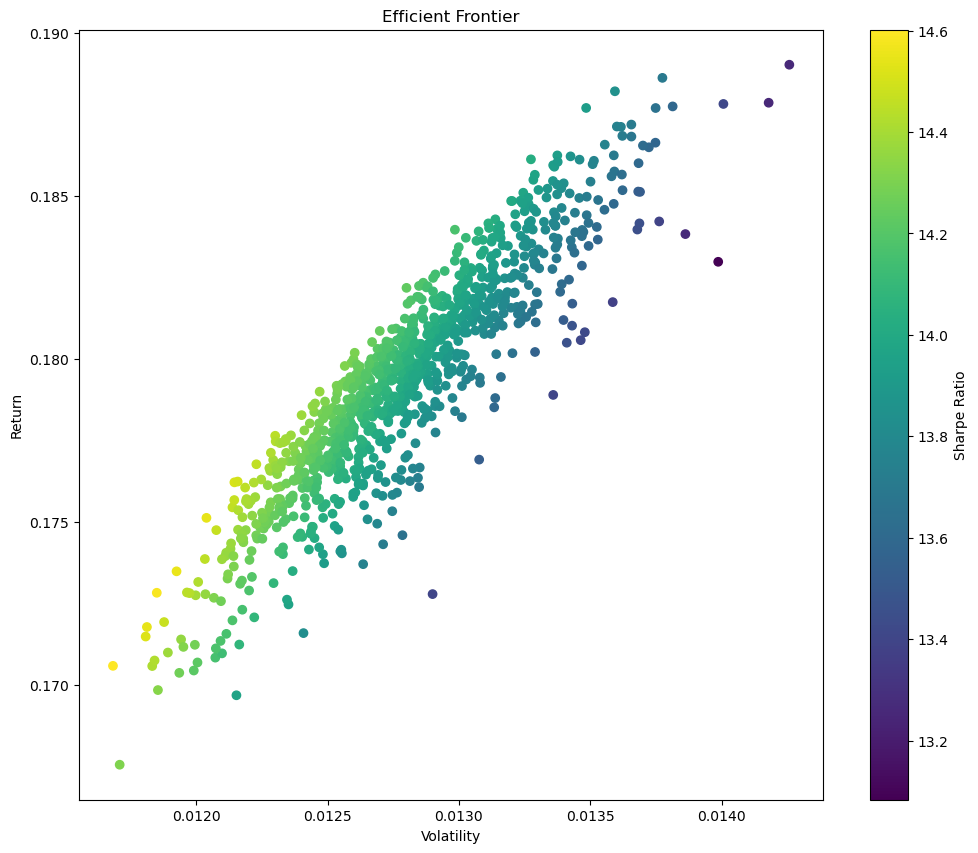

In [52]:
# Step 1: Define the expected returns and volatilities for each security
# correlation_matrix = master_data[[scrip + '_returns' for scrip, _ in portfolio_stocks]].corr().to_numpy()
securities = [scrip for scrip in scrips]
expected_returns = realized_returns['ExpectedReturn'].to_numpy()
volatilities = realized_returns['DailyVolatility'].to_numpy()

# Step 2: Calculate the covariance matrix
cov_matrix = covariance_matrix
# cov_matrix = np.outer(volatilities, volatilities) * correlation_matrix

# Step 3: Generate random portfolios
num_portfolios = 1000
results = np.zeros((3, num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(len(securities))
    weights /= np.sum(weights)
    
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = results[0,i] / results[1,i]  # Sharpe Ratio

# Step 4: Plot the efficient frontier
plt.figure(figsize=(12, 10))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.show()

Next, I'll compute the capital allocation line

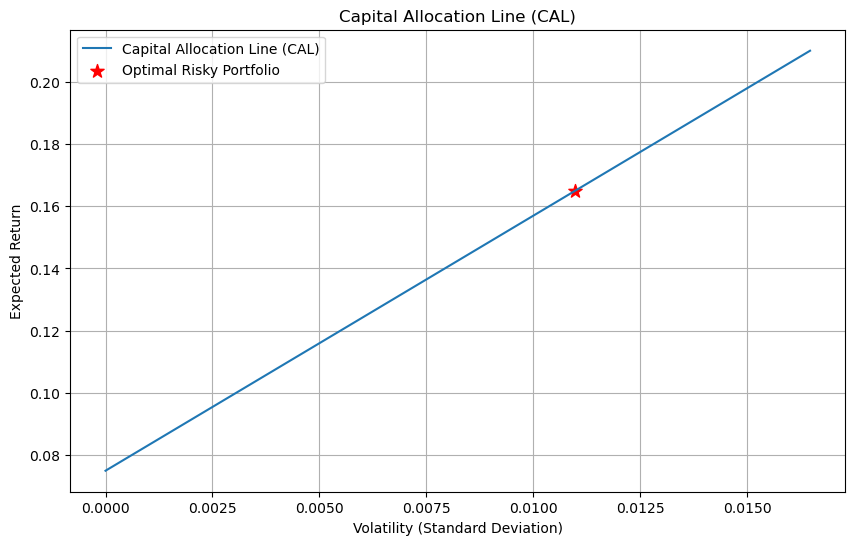

In [53]:
# Define the number of securities
num_securities = len(securities)

# Define the objective function to minimize (negative Sharpe ratio)
def objective(weights):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return -sharpe_ratio

# Define the constraint for acceptable volatility
def volatility_constraint(weights):
    return ACCEPTABLE_VOLATILITY - np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Define the constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
               {'type': 'ineq', 'fun': volatility_constraint})
bounds = tuple((0, 1) for _ in range(num_securities))

# Initial guess for the weights
initial_guess = num_securities * [1. / num_securities]

# Perform the optimization
result = minimize(objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

# Get the optimal weights
optimal_weights = result.x

# Calculate the expected return and volatility of the optimal risky portfolio
optimal_portfolio_return = np.dot(optimal_weights, expected_returns)
optimal_portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))

# Generate the Capital Allocation Line (CAL)
cal_returns = []
cal_volatilities = []

for weight in np.linspace(0, 1.5, 100):
    cal_return = RISK_FREE_RETURN + weight * (optimal_portfolio_return - RISK_FREE_RETURN)
    cal_volatility = weight * optimal_portfolio_volatility
    cal_returns.append(cal_return)
    cal_volatilities.append(cal_volatility)

# Plot the CAL
plt.figure(figsize=(10, 6))
plt.plot(cal_volatilities, cal_returns, label='Capital Allocation Line (CAL)')
plt.scatter(optimal_portfolio_volatility, optimal_portfolio_return, color='red', marker='*', s=100, label='Optimal Risky Portfolio')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Capital Allocation Line (CAL)')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
for fund, pct_allocation in zip(scrips, optimal_weights):
    print('\t{0}: {1:.2f}%'.format(fund, pct_allocation * 100))
    
print('\n\nExpected Portfolio Return: {0:.2f}%'.format(np.dot(optimal_weights, expected_returns) * 100))
print('Expected Portfolio Volatility: {0:.2f}%'.format(optimal_portfolio_volatility * 100))

	ARE&M: 3.11%
	AXISBANK: 0.00%
	BAJAJ-AUTO: 8.73%
	BAJAJHLDNG: 5.11%
	COALINDIA: 4.94%
	ENDURANCE: 7.34%
	EXIDEIND: 3.20%
	GESHIP: 4.12%
	HDFCBANK: 13.30%
	HEROMOTOCO: 3.35%
	ICICIBANK: 4.65%
	IDFCFIRSTB: 0.00%
	ITC: 13.87%
	KOTAKBANK: 7.38%
	KPITTECH: 3.25%
	M&M: 1.76%
	MOTHERSON: 0.00%
	NMDC: 0.54%
	POWERGRID: 10.22%
	SUNDRMFAST: 5.13%
	TATAPOWER: 0.00%


Expected Portfolio Return: 16.50%
Expected Portfolio Volatility: 1.10%


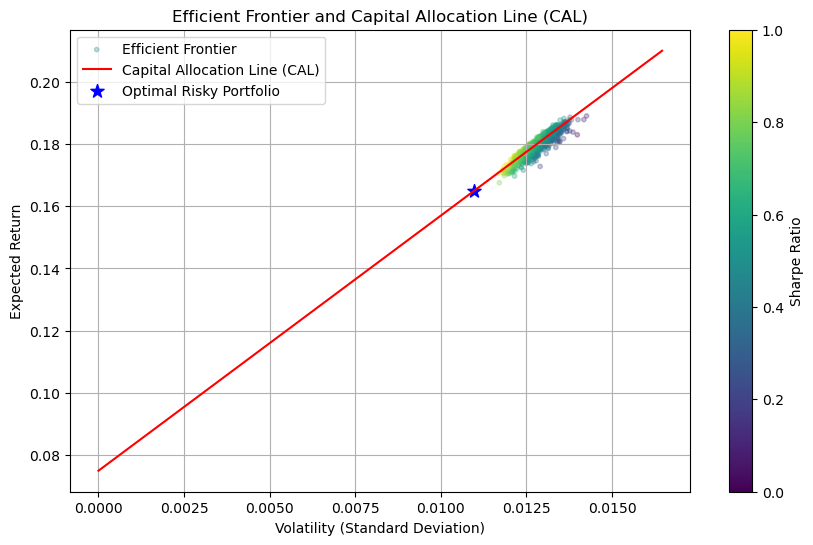

In [55]:
# Plot the CAL and the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o', s=10, alpha=0.3, label='Efficient Frontier')
plt.plot(cal_volatilities, cal_returns, label='Capital Allocation Line (CAL)', color='red')
plt.scatter(optimal_portfolio_volatility, optimal_portfolio_return, color='blue', marker='*', s=100, label='Optimal Risky Portfolio')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier and Capital Allocation Line (CAL)')
plt.colorbar(label='Sharpe Ratio')
plt.legend()
plt.grid(True)
plt.show()